<center>
<h1>f2py</h1>
<br>

<h2> Python fo computational science </h2>
<h3> CINECA, 16-18 October 2017 </h3>

<h3> m.cestari@cineca.it </h3>

</center> 

## f2py
* f2py allows to build an extension module that interfaces Python to Fortran 77/90/95 routines
* Let's write a Fortran function to interface a simple array_multiply routine


## matmul example

In [1]:
%%writefile mult.f90

subroutine fmult(a,b,c,n)
implicit none
real*8 :: a(*)
real*8 :: b(*)
real*8 :: c(*)
integer :: n, i
do i =1,n
  c(i) = a(i) * b(i)
enddo
end

Overwriting mult.f90


In [3]:
!f2py -c -m mult mult.f90  

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "mult" sources
f2py options: []
f2py:> /tmp/tmpod6hdmpg/src.linux-x86_64-3.6/multmodule.c
creating /tmp/tmpod6hdmpg/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'mult.f90' (format:free)
Post-processing...
	Block: mult
			Block: fmult
Post-processing (stage 2)...
Building modules...
	Building module "mult"...
		Constructing wrapper function "fmult"...
getarrdims:warning: assumed shape array, using 0 instead of '*'
getarrdims:warning: assumed shape array, using 0 instead of '*'
getarrdims:warning: assumed shape array, using 0 instead of '*'
		  fmult(a,b,c,n)
	Wrote C/API module "mult" to file "/tmp/tmpod6hdmpg/src.linux-x86_64-3.6/multmodule.c"
  adding '/tmp/tmpod6hdmpg/src.linux-x86_64-3.6/fortranobject.c' to

In [4]:
# now we can import the module mult.so
import mult
print(mult.fmult.__doc__)

fmult(a,b,c,n)

Wrapper for ``fmult``.

Parameters
----------
a : input rank-1 array('d') with bounds (*)
b : input rank-1 array('d') with bounds (*)
c : input rank-1 array('d') with bounds (*)
n : input int



In [5]:
import numpy as np
a = np.ones(10000)+ 3 
b = np.ones(10000)+ 1.5
c = np.empty(a.size)
mult.fmult(a,b,c,a.size)
c

array([ 10.,  10.,  10., ...,  10.,  10.,  10.])

## f2py: improving interface
* One can improve the interface automatically built to make it more pythonic

In [ ]:
!f2py -h mult.pyf -m mult mult.f90

In [ ]:
!cat mult.pyf

## Let's adapt the interface to be more pythonic

In [ ]:
%%writefile mult.pyf

!    -*- f90 -*-
! Note: the context of this file is case sensitive.

python module mult ! in 
    interface  ! in :mult
        subroutine fmult(a,b,c,n) ! in :mult:mult.f90
            real*8 dimension(n) :: a
            real*8 dimension(n) :: b
            real*8 intent(out), dimension(n) :: c
            integer intent(hide), depend(a) :: n=len(a)
        end subroutine fmult
    end interface 
end python module mult

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/

In [ ]:
!rm mult.cpython-34m.so
!f2py3 -c -m mult mult.pyf mult.f90

In [ ]:
import mult
print(mult.fmult.__doc__)

## f2py: improving the interface 

* Inserting directives in fortran source to make the function more pythonic

In [6]:
%%writefile mult2.f90

subroutine fmult(a,b,c,n)
implicit none
real*8 :: a(n)
real*8 :: b(n)
real*8 :: c(n)
integer :: n, i
!f2py intent(hide), depend(a) :: n=len(a)
!f2py real*8 :: a(n)
!f2py real*8 :: b(n)
!f2py real*8, intent(out) :: c(n)
do i =1,n
  c(i) = a(i) * b(i)
enddo
end


Writing mult2.f90


In [7]:
!diff mult.f90 mult2.f90

4,6c4,6
< real*8 :: a(*)
< real*8 :: b(*)
< real*8 :: c(*)
---
> real*8 :: a(n)
> real*8 :: b(n)
> real*8 :: c(n)
7a8,11
> !f2py intent(hide), depend(a) :: n=len(a)
> !f2py real*8 :: a(n)
> !f2py real*8 :: b(n)
> !f2py real*8, intent(out) :: c(n)


In [8]:
!f2py -c -m mult2 mult2.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "mult2" sources
f2py options: []
f2py:> /tmp/tmpf_j8sq4l/src.linux-x86_64-3.6/mult2module.c
creating /tmp/tmpf_j8sq4l/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'mult2.f90' (format:free)
Line #8 in mult2.f90:"      intent(hide), depend(a) :: n=len(a)"
	analyzeline: cannot handle multiple attributes without type specification. Ignoring ' depend(a)'.
Post-processing...
	Block: mult2
			Block: fmult
Post-processing (stage 2)...
Building modules...
	Building module "mult2"...
		Constructing wrapper function "fmult"...
		  c = fmult(a,b)
	Wrote C/API module "mult2" to file "/tmp/tmpf_j8sq4l/src.linux-x86_64-3.6/mult2module.c"
  adding '/tmp/tmpf_j8sq4l/src.linux-x86_64-3.6/fortranobject.c' to sources.
  adding '/

In [9]:
import mult2
print(mult2.fmult.__doc__)

c = fmult(a,b)

Wrapper for ``fmult``.

Parameters
----------
a : input rank-1 array('d') with bounds (n)
b : input rank-1 array('d') with bounds (n)

Returns
-------
c : rank-1 array('d') with bounds (n)



In [10]:
import numpy as np

In [11]:
a = np.array([1, 3, 4])
b = np.array([2, 5, 1.5])
c = mult2.fmult(a, b) 
c

array([  2.,  15.,   6.])

In [12]:
a = np.arange(1, 10**6, 1.1)
b = a.copy()

In [13]:
%timeit a*b 

1.12 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit mult2.fmult(a,b)

1.47 ms ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## second example: mandelbrot

This fractal is defined by the iteration

$$z ← z^2 + c$$

where z and c are complex variables. This expression is iterated; if z stays finite, c belongs to the Mandelbrot set


In [15]:
%%writefile mandel.f90

subroutine single_point_mandelbrot(z,c,zout)
    ! *************************************************
    ! * compute single point mandlebrot *
    ! *************************************************
    implicit none
    integer :: I 
    complex*16 :: z, c, zout
    do i = 1,100
        z = z*z + c
        if ((real(z)**2 + aimag(z)**2 ) .gt. 1000.0) then
           exit
        endif 
    enddo
    zout = z
end subroutine

Writing mandel.f90


## mandelbrot/2
Let us get the new module a more pythonic interface


In [16]:
%%writefile mandel2.f90

subroutine single_point_mandelbrot(z,c,zout)
    ! *************************************************
    ! * compute single point mandlebrot *
    ! *************************************************
    implicit none
    integer :: I 
    complex*16 :: z, c, zout 
    !f2py complex*16, intent(out) :: zout 
    do i = 1,100
        z = z*z + c
        if ((real(z)**2 + aimag(z)**2 ) .gt. 1000.0) then
           exit
        endif 
    enddo
    zout = z
end subroutine

Writing mandel2.f90


In [17]:
!f2py -c -m mandel mandel2.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "mandel" sources
f2py options: []
f2py:> /tmp/tmpc651ljwz/src.linux-x86_64-3.6/mandelmodule.c
creating /tmp/tmpc651ljwz/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'mandel2.f90' (format:free)
Post-processing...
	Block: mandel
			Block: single_point_mandelbrot
Post-processing (stage 2)...
Building modules...
	Building module "mandel"...
		Constructing wrapper function "single_point_mandelbrot"...
		  zout = single_point_mandelbrot(z,c)
	Wrote C/API module "mandel" to file "/tmp/tmpc651ljwz/src.linux-x86_64-3.6/mandelmodule.c"
  adding '/tmp/tmpc651ljwz/src.linux-x86_64-3.6/fortranobject.c' to sources.
  adding '/tmp/tmpc651ljwz/src.linux-x86_64-3.6' to include_dirs.
copying /home/mirko/lavoro/usr/anaconda3/lib

In [18]:
import mandel
print(mandel.single_point_mandelbrot.__doc__)

zout = single_point_mandelbrot(z,c)

Wrapper for ``single_point_mandelbrot``.

Parameters
----------
z : input complex
c : input complex

Returns
-------
zout : complex



## mandelbrot/3
* Let's test the module (and the interface)


In [19]:
z = complex(1,2)
c = complex(1,2)
zout = mandel.single_point_mandelbrot(z,c)
zout 

(-31-22j)

## mandelbrot/4
* Now we can employ our function
* First, we need to wrap our function


In [20]:
def myfunc(a,b):
    return mandel.single_point_mandelbrot(a,b)

* And then vectorize it


In [21]:
vfunc = np.vectorize(myfunc) #now we can use madel.single_point_mandelbrot as a ufunc 

* Let's build the input points ...

In [22]:
x = np.linspace(-1.7, 0.6, 1000)
y = np.linspace(-1.4, 1.4, 1000)
xx, yy = np.meshgrid(x, y)  
xx.shape

(1000, 1000)

* ... and then get the complex numbers


In [23]:
def f(aa, bb):
    return aa + 1j*bb  

ff = f(xx, yy)  # build a 2d array of complex numbers

*  Now we can use our new function and plot the results

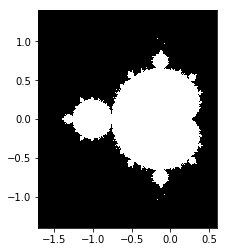

In [24]:
z = vfunc(ff,ff) # just used our single_point_mandelbrot func
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(abs(z)**2 < 1000, extent=[-1.7, 0.6, -1.4, 1.4])
plt.gray()
plt.show()